In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

Illegal line #217
	"       - 'Nanum'
"
	in file "/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"


## Images

#### 인물

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/조정석.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1080, 2220, 3)


#### 멍멍이

In [3]:
# 멍멍이1
dog_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/백호.jpg'   
dog_img_orig = cv2.imread(dog_img_path) 
print (dog_img_orig.shape)

(1040, 1080, 3)


In [24]:
# 멍멍이2
dog2_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/백호.jpeg'   
dog2_img_orig = cv2.imread(dog2_img_path) 
print (dog2_img_orig.shape)

(1667, 2000, 3)


#### 야옹이

In [34]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/호랑이.jpeg'   
cat_img_orig = cv2.imread(cat_img_path) 
print (cat_img_orig.shape)

(768, 1024, 3)


#### 배경_우주

In [5]:
uni_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/우주.jpg'   
uni_img_orig = cv2.imread(uni_img_path) 
print (uni_img_orig.shape)

(373, 800, 3)


## model

In [7]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [8]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

#### 인물

In [10]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1080, 2220, 3) (249, 513, 3) 15


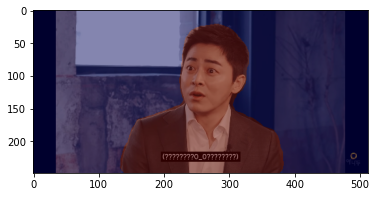

In [11]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

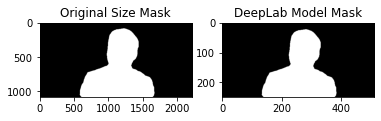

In [12]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

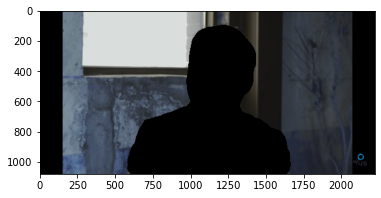

In [13]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

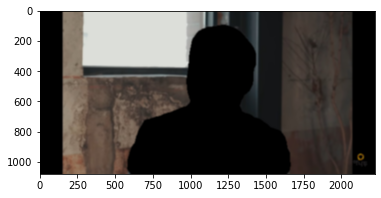

In [14]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

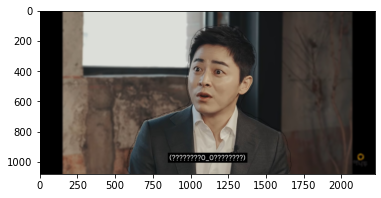

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

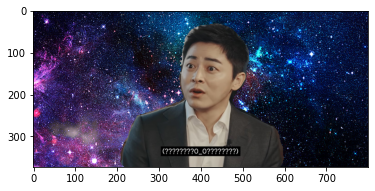

In [16]:
img_resized = cv2.resize(
    img_orig, (uni_img_orig.shape[1], uni_img_orig.shape[0]))
img_mask_resized = cv2.resize(
    img_mask_color, (uni_img_orig.shape[1], uni_img_orig.shape[0]))

img_uni_concat = np.where(
    img_mask_resized == 255, img_resized, uni_img_orig)

plt.imshow(cv2.cvtColor(img_uni_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 멍멍이

In [22]:
dog_img_resized, dog_seg_map = MODEL.run(dog_img_orig)
print (dog_img_orig.shape, dog_img_resized.shape, dog_seg_map.max())

(1040, 1080, 3) (494, 513, 3) 8


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


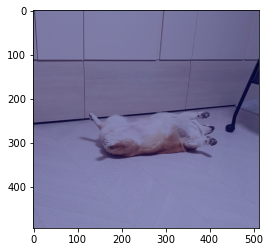

In [23]:
dog_img_show = dog_img_resized.copy()
dog_seg_map = np.where(dog_seg_map == 12, 12, 0)
dog_img_mask = dog_seg_map * (255/dog_seg_map.max()) # 255 normalization
dog_img_mask = dog_img_mask.astype(np.uint8)
dog_color_mask = cv2.applyColorMap(dog_img_mask, cv2.COLORMAP_JET)
dog_img_show = cv2.addWeighted(dog_img_show, 0.6, dog_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(dog_img_show, cv2.COLOR_BGR2RGB))
plt.show()

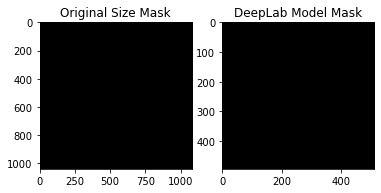

In [25]:
dog_img_mask_up = cv2.resize(dog_img_mask, dog_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, dog_img_mask_up = cv2.threshold(dog_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(dog_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(dog_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- 누워있는 강아지 인식 실패
- 강아지 얼굴이 보이지 않아서 강아지라고 인식하지 못하는 것 같다

In [27]:
dog2_img_resized, dog2_seg_map = MODEL.run(dog2_img_orig)
print (dog2_img_orig.shape, dog2_img_resized.shape, dog2_seg_map.max())

(1667, 2000, 3) (427, 513, 3) 15


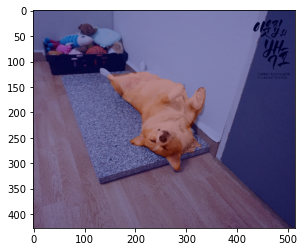

In [28]:
dog2_img_show = dog2_img_resized.copy()
dog2_seg_map = np.where(dog2_seg_map == 12, 12, 0)
dog2_img_mask = dog2_seg_map * (255/dog2_seg_map.max()) # 255 normalization
dog2_img_mask = dog2_img_mask.astype(np.uint8)
dog2_color_mask = cv2.applyColorMap(dog2_img_mask, cv2.COLORMAP_JET)
dog2_img_show = cv2.addWeighted(dog2_img_show, 0.6, dog2_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(dog2_img_show, cv2.COLOR_BGR2RGB))
plt.show()

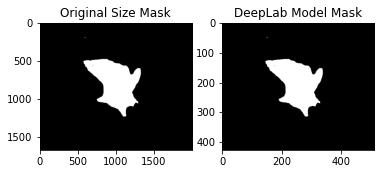

In [29]:
dog2_img_mask_up = cv2.resize(dog2_img_mask, dog2_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, dog2_img_mask_up = cv2.threshold(dog2_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(dog2_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(dog2_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

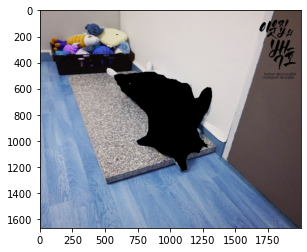

In [30]:
dog2_img_mask_color = cv2.cvtColor(dog2_img_mask_up, cv2.COLOR_GRAY2BGR)
dog2_img_bg_mask = cv2.bitwise_not(dog2_img_mask_color)
dog2_img_bg = cv2.bitwise_and(dog2_img_orig, dog2_img_bg_mask)
plt.imshow(dog2_img_bg)
plt.show()

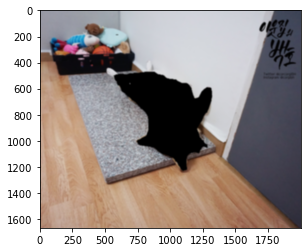

In [31]:
dog2_img_bg_blur = cv2.blur(dog2_img_bg, (13,13))
plt.imshow(cv2.cvtColor(dog2_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

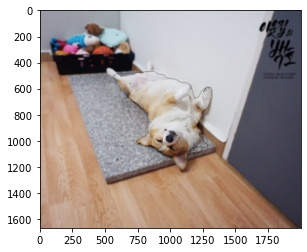

In [32]:
dog2_img_concat = np.where(dog2_img_mask_color==255, dog2_img_orig, dog2_img_bg_blur)
plt.imshow(cv2.cvtColor(dog2_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

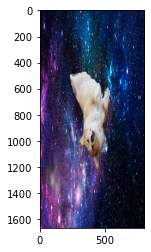

In [42]:
dog2_resized = cv2.resize(
    dog2_img_orig, (uni_img_orig.shape[1], dog2_img_orig.shape[0]))
uni_img_resized = cv2.resize(
    uni_img_orig, (uni_img_orig.shape[1], dog2_img_orig.shape[0]))
dog2_img_mask_resized = cv2.resize(
    dog2_img_mask_color, (uni_img_orig.shape[1], dog2_img_orig.shape[0]))

dog2_uni_concat = np.where(
    dog2_img_mask_resized == 255, dog2_resized, uni_img_resized)

plt.imshow(cv2.cvtColor(dog2_uni_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 누워있는 강아지지만, 이전 사진과는 다르게 얼굴이 보인다. 그래서 누워있어도 개라고 인식하고, segmentation이 됐다.

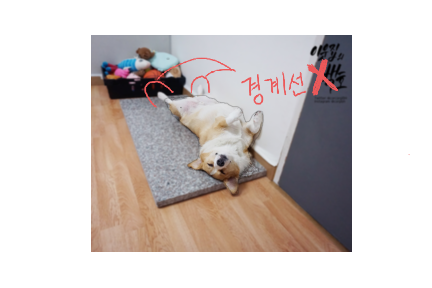

In [45]:
from IPython.display import Image
Image("problem1.png")

- 하지만 강아지 뒷발을 구분하지 못하고 경계선이 그려져있다. 
- 그래서 크로마키 배경 합성하였을때 강아지 뒷발이 날아갔다..

### 고양이

In [35]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(768, 1024, 3) (384, 513, 3) 15


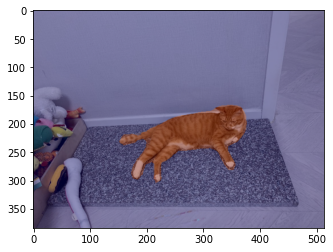

In [36]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0)
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

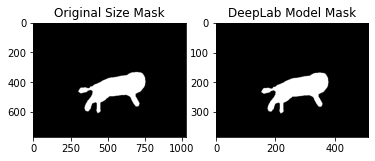

In [37]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

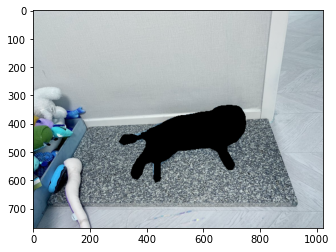

In [38]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

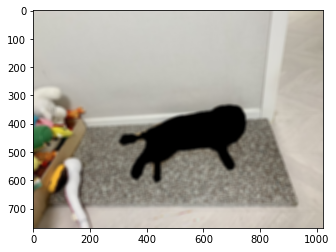

In [39]:
cat_img_bg_blur = cv2.blur(cat_img_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

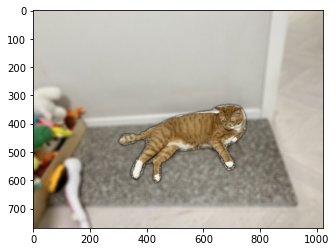

In [40]:
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

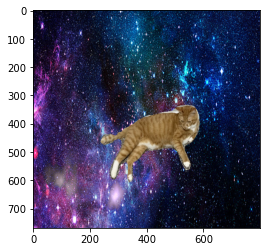

In [41]:
cat_resized = cv2.resize(
    cat_img_orig, (uni_img_orig.shape[1], cat_img_orig.shape[0]))
uni_img_resized = cv2.resize(
    uni_img_orig, (uni_img_orig.shape[1], cat_img_orig.shape[0]))
cat_img_mask_resized = cv2.resize(
    cat_img_mask_color, (uni_img_orig.shape[1], cat_img_orig.shape[0]))

cat_uni_concat = np.where(
    cat_img_mask_resized == 255, cat_resized, uni_img_resized)

plt.imshow(cv2.cvtColor(cat_uni_concat, cv2.COLOR_BGR2RGB))
plt.show()

- (누워있는 강아지에 비해) 온전한 고양이 모습이라서 고양이가 전체적으로 경계선이 잘 그어졌다.
- 그러나 (여러사진들의 결과물 포함) 그 경계선이 자연스럽지 못하다. 

- 인물모드 사진의 문제점을 개선할 수 있는 솔루션........ 잘 모르겠다.